In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

In [2]:
# Load the CSV data into a DataFrame
df = pd.read_csv('flights/flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'column type'})

# Append information about the number of null values in each column
tab_info = pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'null values (nb)'})], axis=0)

# Append information about the percentage of null values in each column
tab_info = pd.concat([tab_info, pd.DataFrame(df.isnull().sum() / df.shape[0] * 100)
                     .T.rename(index={0: 'null values (%)'})], axis=0)

Dataframe dimensions: (5819079, 31)


In [3]:
airports = pd.read_csv('airports.csv')

c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\transformer.py:820: UserWarning: Warning: converting a mas

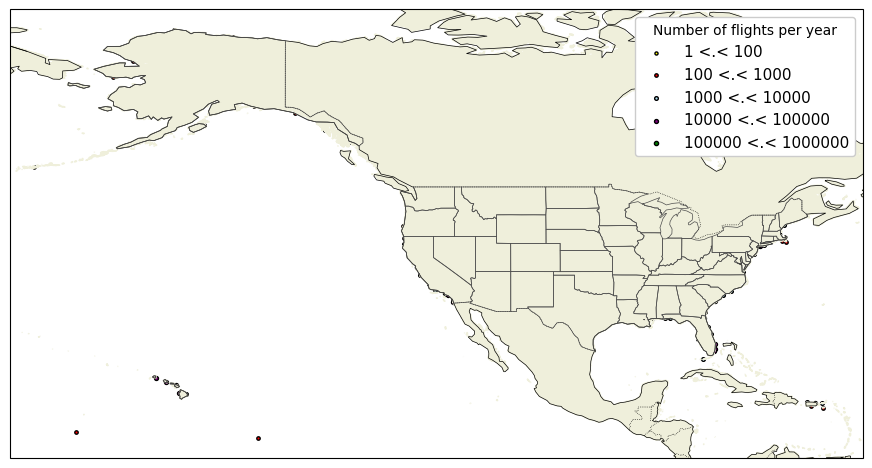

In [4]:
count_flights = df['ORIGIN_AIRPORT'].value_counts()

# Define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits) - 1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i + 1]))

# Create a figure and axis with Cartopy projection
fig = plt.figure(figsize=(11, 11))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add shaded relief, coastlines, countries, and states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land']))
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='0.3')

# Assume 'airports' DataFrame contains the airport data
for index, (code, lat, lon) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    ax.scatter(lon, lat, marker='o', s=ind + 5, edgecolor='k', color=colors[ind], label=labels[ind])

# Remove duplicate labels and set their order
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000', '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]

# Add the legend to the plot
plt.legend(new_label.values(), new_label.keys(), loc=1, prop={'size': 11}, title='Number of flights per year', frameon=True, framealpha=1)
plt.show()

In [5]:
df = df[df['MONTH'] == 1]

In [6]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [7]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [8]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [9]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [10]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [11]:
df.dropna(inplace = True)

In [12]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [13]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [14]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\2300760565.py:59: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\2300760565.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'norm

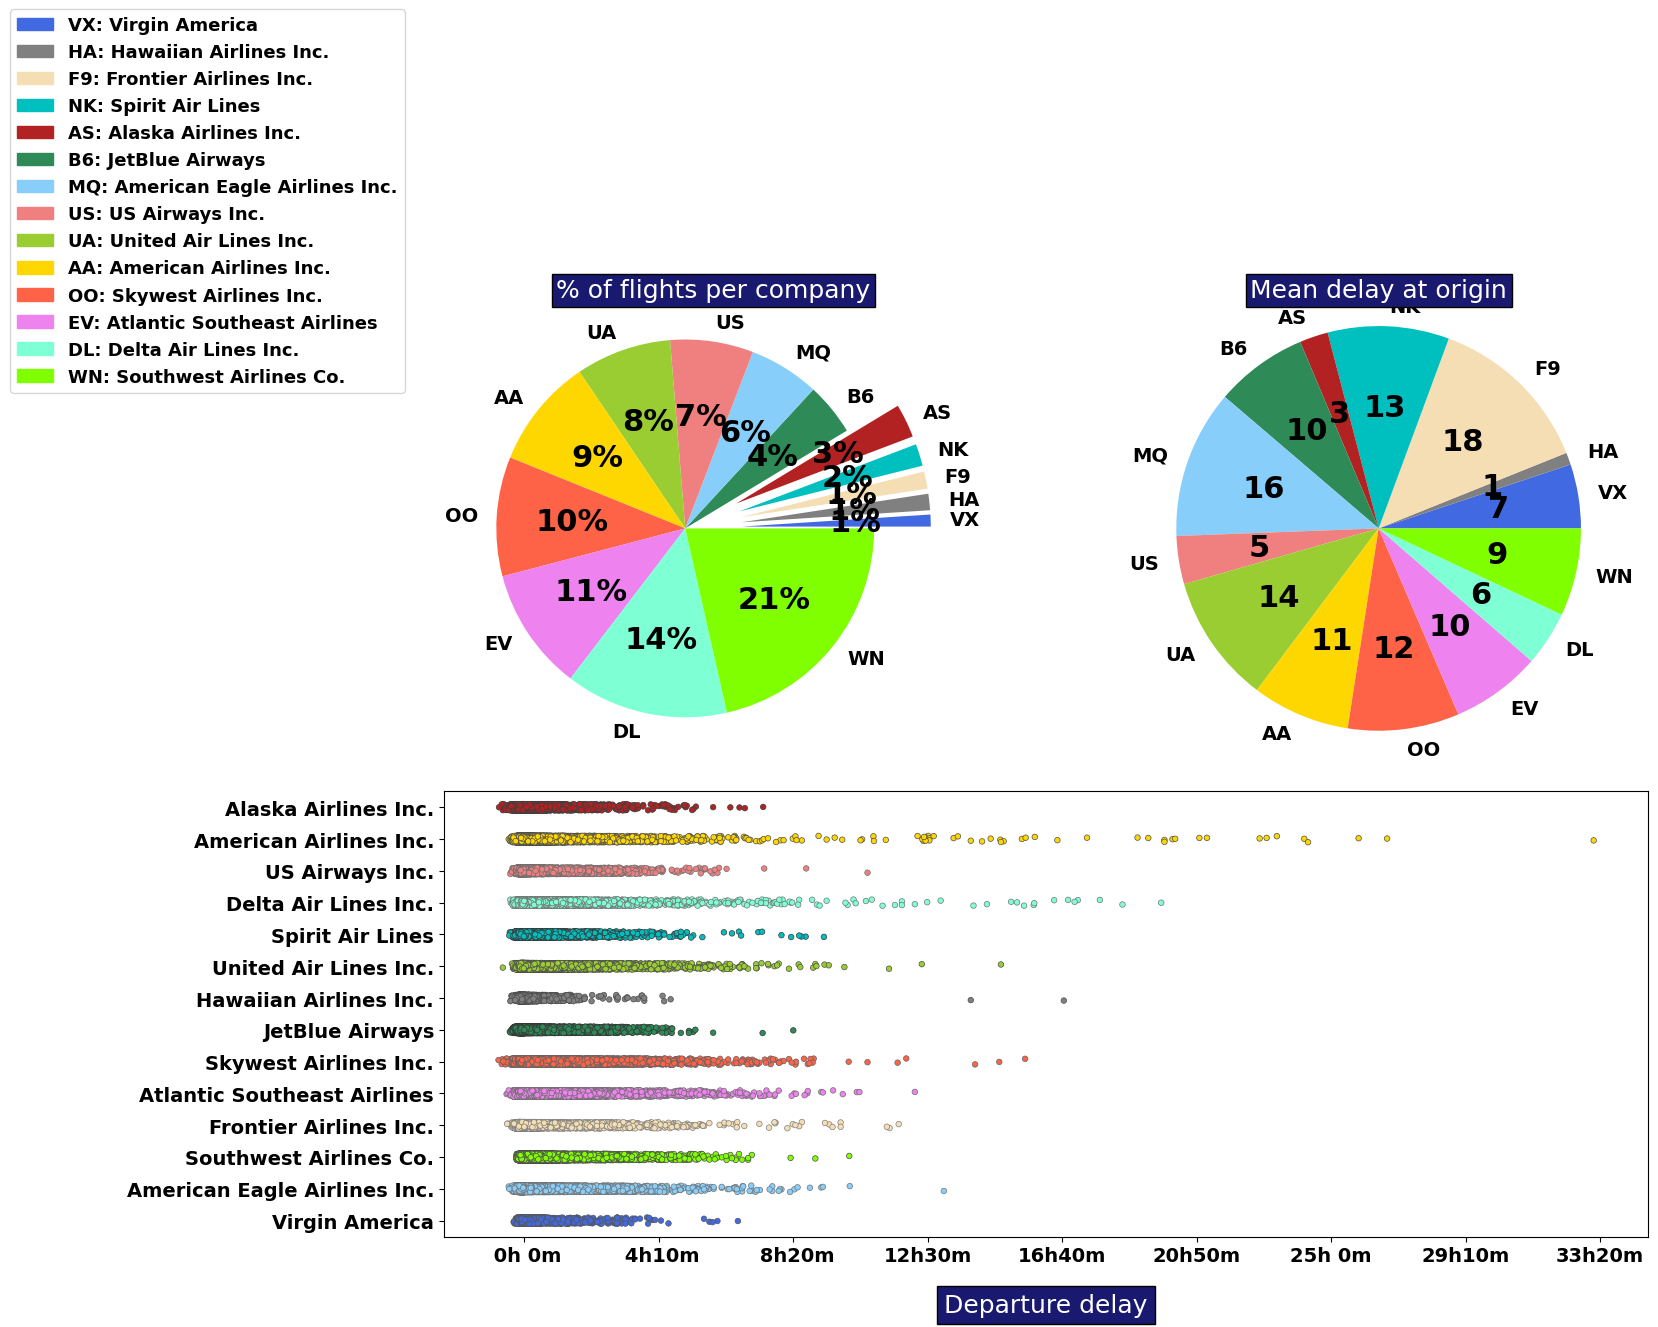

In [15]:
font = {'family': 'normal', 'weight': 'bold', 'size': 22}
plt.rc('font', **font)

# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

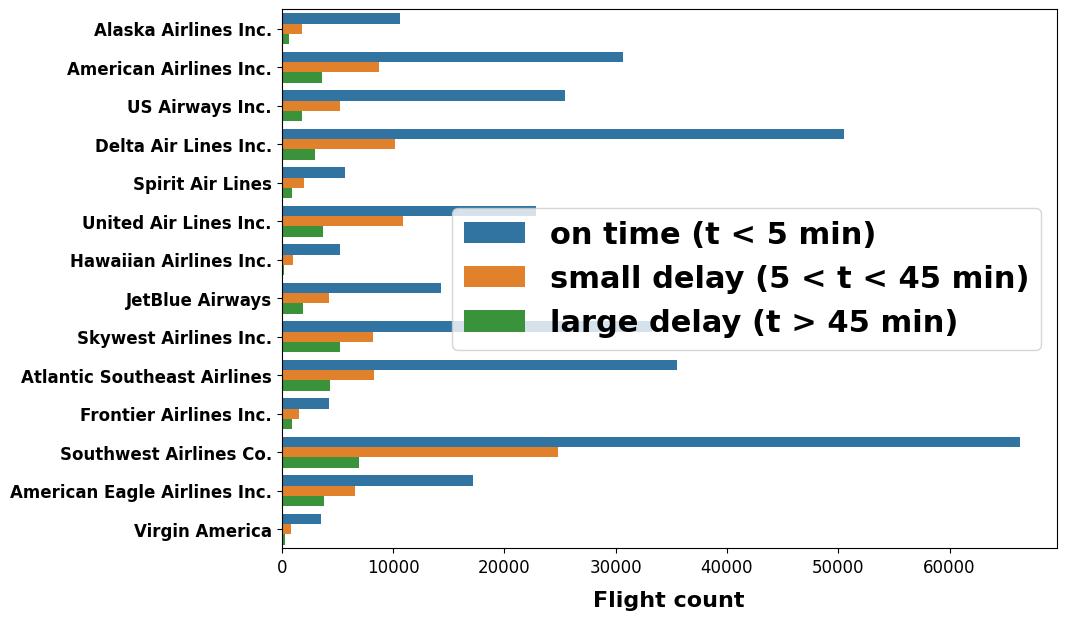

In [16]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3716855487.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for x in ax.get_xticks()])
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3716855487.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font 

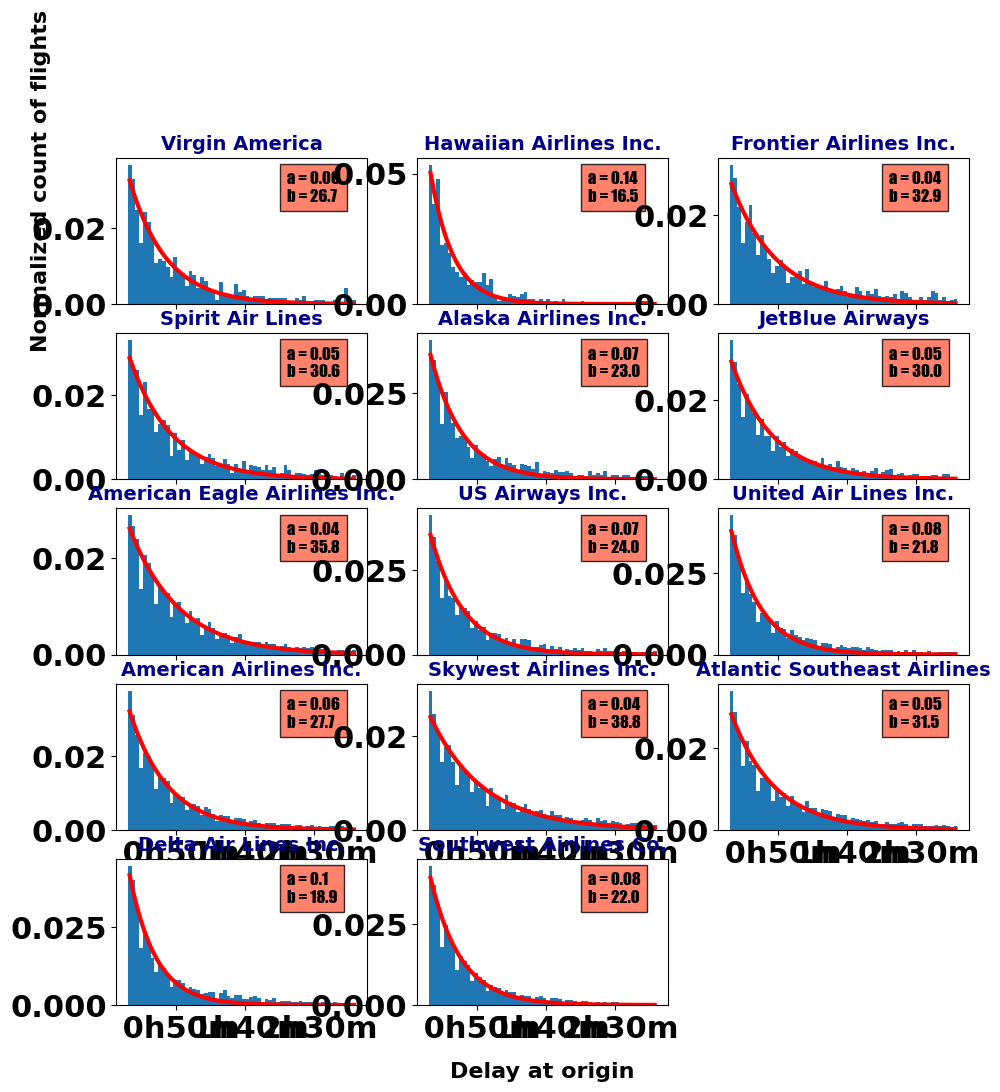

In [17]:
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    # Fit of the distribution
    n, bins, patches = plt.hist(x=df2[df2['AIRLINE'] == carrier_name]['DEPARTURE_DELAY'],
                            range=(15, 180), density=True, bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

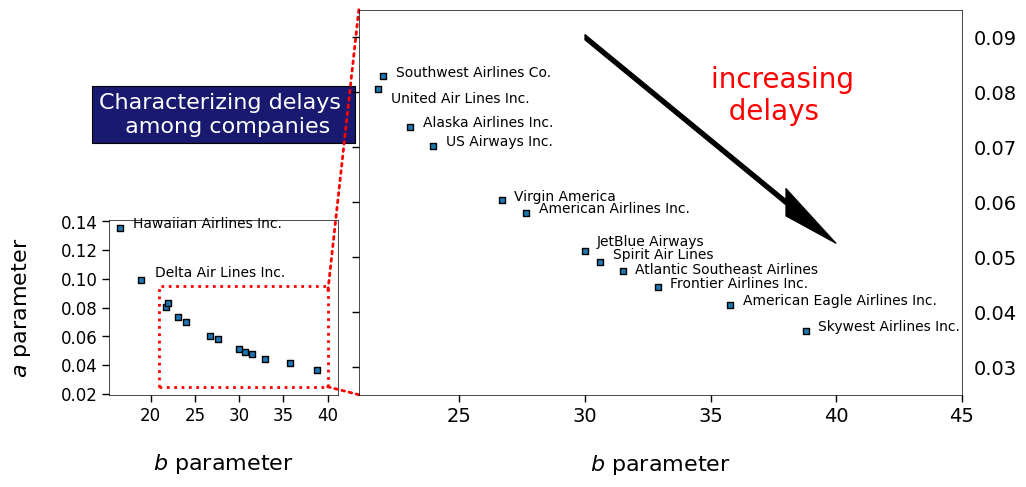

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker='s', edgecolor='black', linewidth=1)
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolor='black', linewidth=1)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

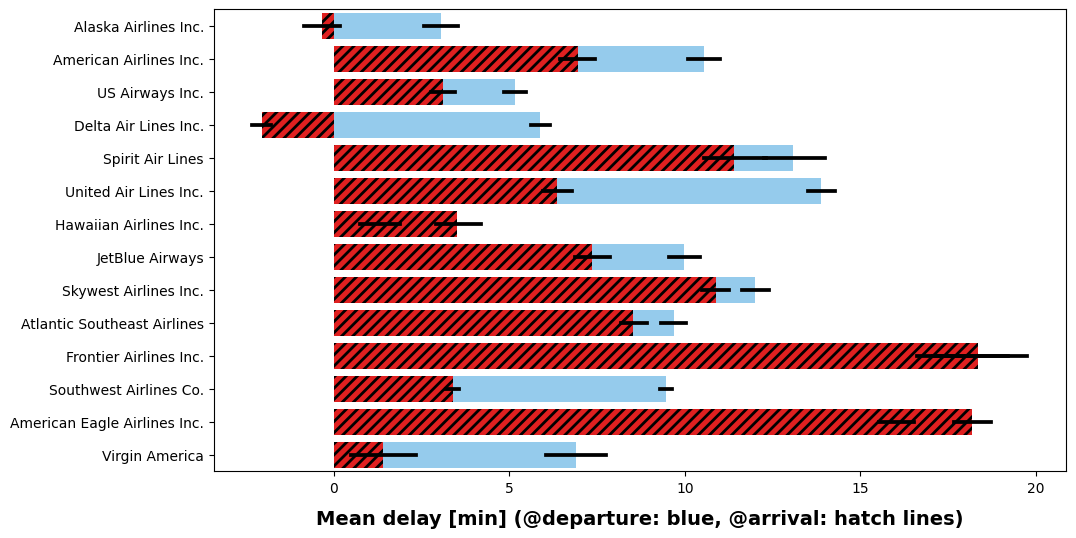

In [19]:
# Reset matplotlib rcParams to defaults
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['hatch.linewidth'] = 2.0

# Create a figure
fig, ax = plt.subplots(figsize=(11, 6))

# Create bar plots for departure and arrival delays
sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", errcolor="black")
sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="red", hatch='///', errcolor="black")

# Set y-axis labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

# Hide y-axis label
ax.yaxis.label.set_visible(False)

# Set x-axis label
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)', fontsize=14, weight='bold', labelpad=10)
plt.show()

In [20]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312


In [21]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

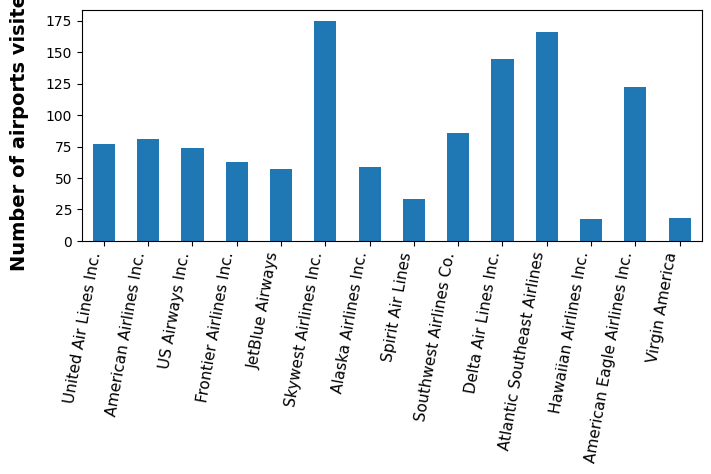

In [22]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [23]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [24]:
def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_axes([0., 0., 1., 1.], projection=ccrs.PlateCarree())

    df2 = df[df['AIRLINE'] == carrier]
    count_trajectories = df2.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size()
    count_trajectories.sort_values(inplace=True)

    # Set up labels for flight segments
    labels = {
        '< 100': {'color': 'b', 'segments': []},
        '100 <.< 200': {'color': 'r', 'segments': []},
        '> 200': {'color': 'gold', 'segments': []}
    }

    for (origin, dest), s in count_trajectories.iteritems():
        nylat, nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or \
                pd.isnull(lonlat) or pd.isnull(lonlon):
            continue
        if s < 100:
            label = '< 100'
        elif s >= 100 and s < 200:
            label = '100 <.< 200'
        else:
            label = '> 200'
        labels[label]['segments'].append((nylat, nylon, lonlat, lonlon))

    # Plot flight segments
    for label in ['< 100', '100 <.< 200', '> 200']:
        color = labels[label]['color']
        segments = labels[label]['segments']
        for segment in segments:
            ax.plot([segment[1], segment[3]], [segment[0], segment[2]], linewidth=0.7, color=color, label=label)

    # Set up legend
    legend_labels = []
    for label, data in labels.items():
        color = data['color']
        legend_labels.append(patches.Patch(color=color, label=label))
    ax.legend(handles=legend_labels, loc='best', prop={'size': 8}, title='flights per month', facecolor='palegreen', shadow=True, frameon=True, framealpha=1)

    # Set map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor='0.3')
    ax.add_feature(cfeature.LAND, color='lightgray')

    # Add gridlines and labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.show()


C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\2538841990.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (origin, dest), s in count_trajectories.iteritems():
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


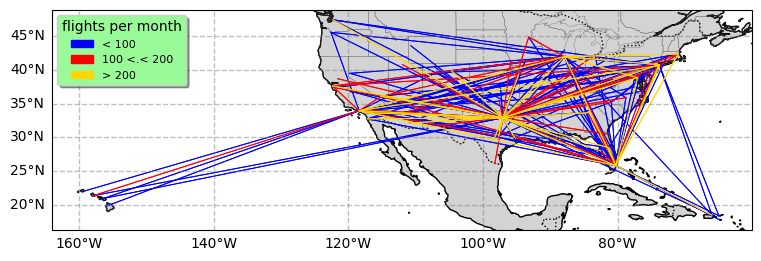

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\2538841990.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (origin, dest), s in count_trajectories.iteritems():
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


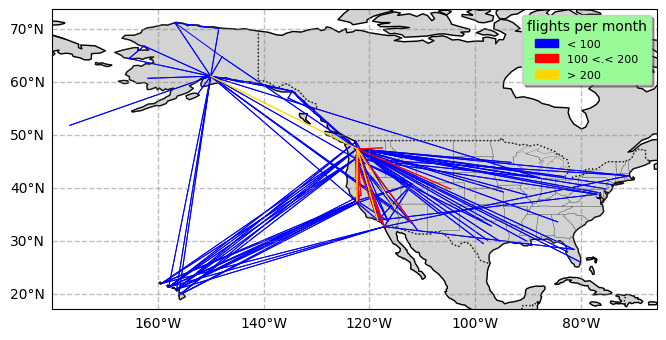

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\2538841990.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (origin, dest), s in count_trajectories.iteritems():
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\Diluksha Shamal\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


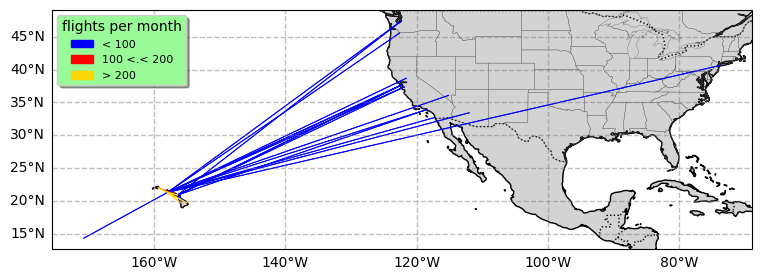

In [25]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA', 'AS', 'HA']: 
    make_map(df, carrier, *coord[carrier])

In [26]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

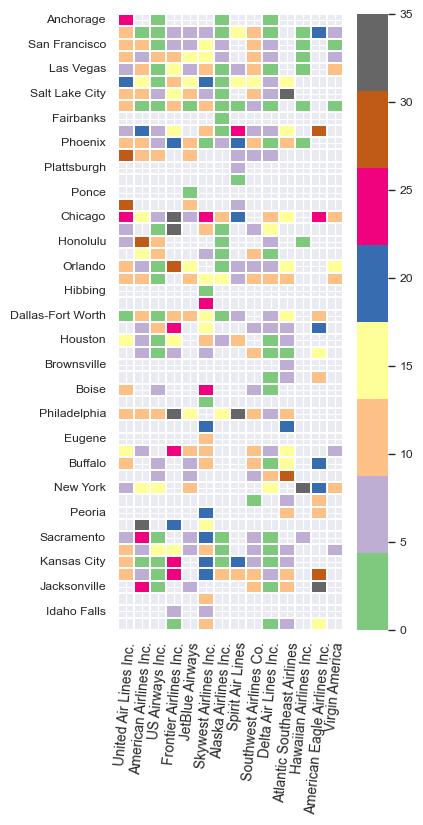

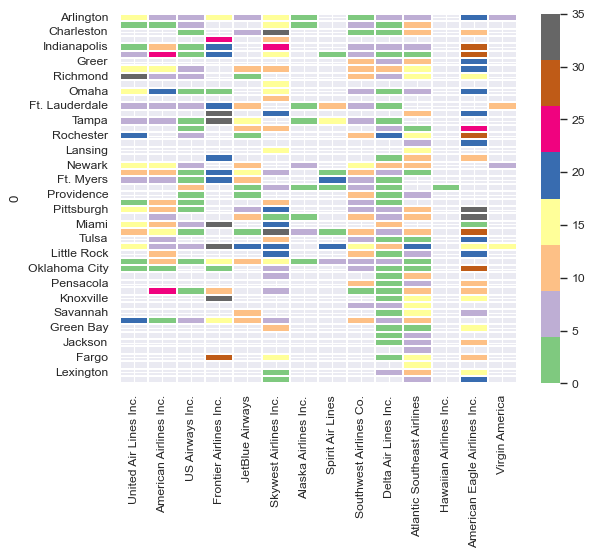

<Figure size 640x480 with 0 Axes>

In [27]:
# Set the context to "paper"
sns.set(context="paper")

fig = plt.figure(1, figsize=(8, 8))

# First heatmap
ax = fig.add_subplot(1, 2, 1)
subset = airport_mean_delays.iloc[:50, :].rename(columns=abbr_companies)
subset = subset.rename(index=identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin=0, vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

plt.show()  # Add this line to display the first heatmap

# Second heatmap
ax = fig.add_subplot(1, 2, 2)
subset = airport_mean_delays.iloc[50:100, :].rename(columns=abbr_companies)
subset = subset.rename(index=identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize=18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin=0, vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

# Add this line to display the second heatmap
plt.show() 

plt.tight_layout()

# Display the plot
plt.show()

In [28]:
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\1147275938.py:14: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_val.append(scipy.mean(trajet2))
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\1147275938.py:15: DeprecationWarning: scipy.std is deprecated and will be removed in SciPy 2.0.0, use numpy.std instead
  std_val.append(scipy.std(trajet2))


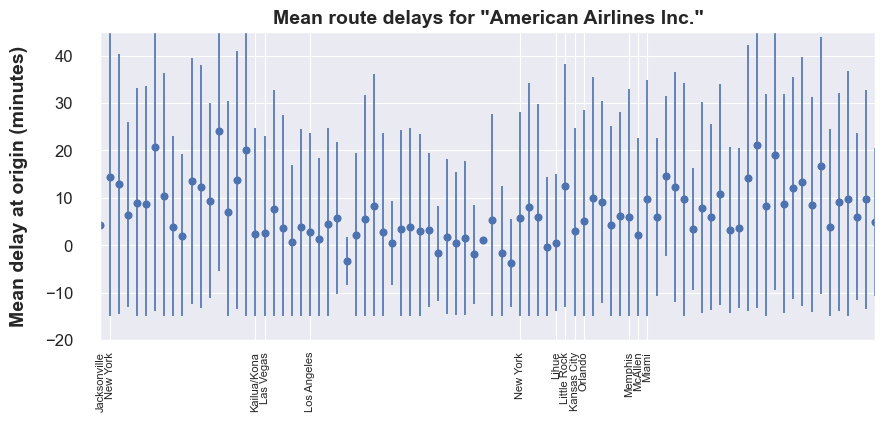

In [29]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

In [30]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])

In [31]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2 = df2.copy()  # Create a copy of df2
df2.sort_values('SCHEDULED_DEPARTURE', inplace=True)

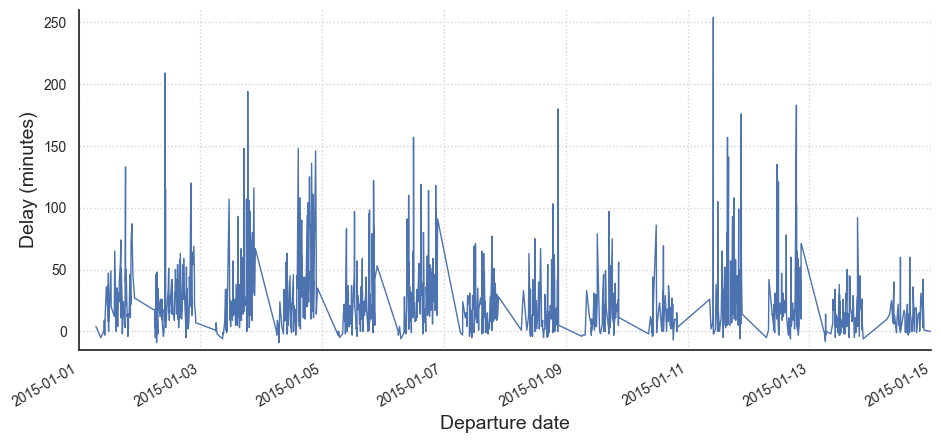

In [32]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)
plt.show()

In [34]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

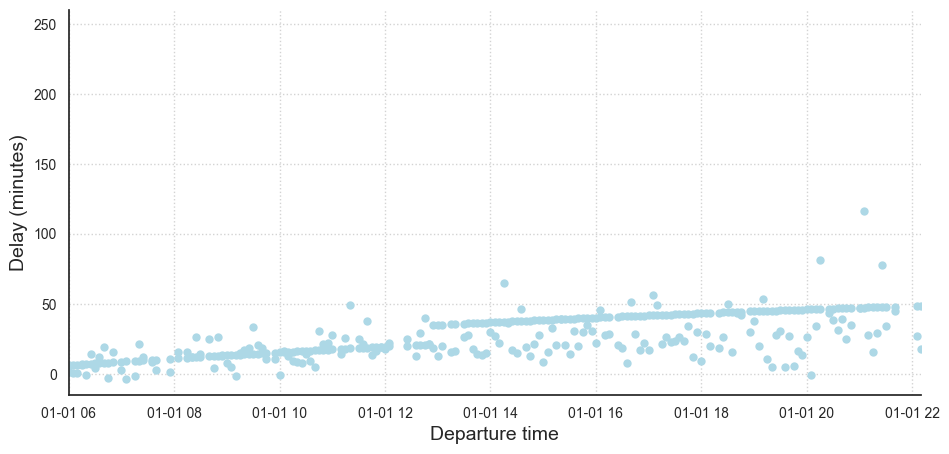

In [46]:
import matplotlib.dates as mdates
datetime_times = [datetime.datetime.combine(datetime.date(2015, 1, 1), t) for t in test2.index]

# Create a Figure_style object
fig1 = Figure_style(11, 5, 1, 1)

# Update the position
fig1.pos_update(0, 0)



# Create a custom line plot for the 'mean' with datetime objects
fig1.cust_plot_date(datetime_times, test2['mean'], linestyle='-', label='Mean')

# Create a custom line plot for the 'fit' with datetime objects
fig1.cust_plot_date(datetime_times, test2['fit'], linestyle='--', linewidth=2, label='Fit', color='r')

# Apply styling
fig1.style()

# Set y-axis label and fontsize
fig1.set_ylabel('Delay (minutes)', fontsize=14)

# Set x-axis label and fontsize
fig1.set_xlabel('Departure time', fontsize=14)

# Set x-axis limits using mdates.date2num
fig1.set_xlim(mdates.date2num(datetime_times[0]), mdates.date2num(datetime_times[-1]))

# Set y-axis limits
fig1.set_ylim(-15, 260)

# Show the plot
plt.show()


In [47]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

In [48]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
JAC,-19.0,47.0,25.0,-3.640000
GUC,-24.0,199.0,22.0,13.227273
SDF,-8.0,55.0,19.0,8.421053
LIT,-5.0,74.0,9.0,12.555556
MTJ,-2.0,51.0,3.0,26.000000


In [49]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [50]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [51]:
id_airport = 'PHL'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\401677547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\401677547.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:10: SettingWithCopyWarning: 

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\809664845.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))


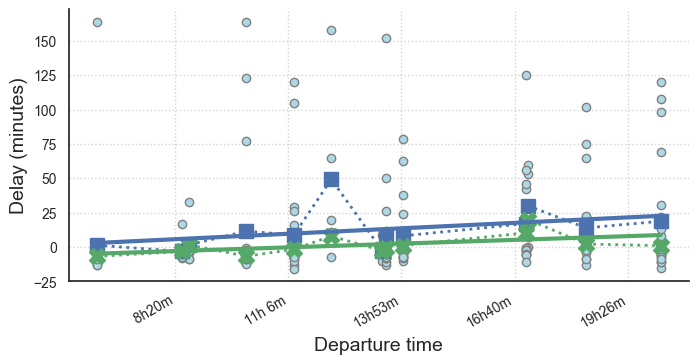

In [54]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()])
plt.show()

In [55]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

modèle nº1 , min. pour n = 1, score = 18.4
modèle nº2 , min. pour n = 1, score = 127.6
modèle nº3 , min. pour n = 3, score = 31.4
modèle nº4 , min. pour n = 1, score = 192.9
modèle nº5 , min. pour n = 1, score = 37.9
modèle nº6 , min. pour n = 1, score = 172.0
modèle nº7 , min. pour n = 1, score = 55.0
modèle nº8 , min. pour n = 1, score = 61.3
modèle nº9 , min. pour n = 1, score = 51.6
modèle nº10, min. pour n = 1, score = 17.1
modèle nº11, min. pour n = 1, score = 45.7
modèle nº12, min. pour n = 1, score = 17.0
modèle nº13, min. pour n = 1, score = 15.8
modèle nº14, min. pour n = 1, score = 24.4
modèle nº15, min. pour n = 1, score = 186.9
modèle nº16, min. pour n = 1, score = 57.1
modèle nº17, min. pour n = 1, score = 137.4
modèle nº18, min. pour n = 2, score = 155.7


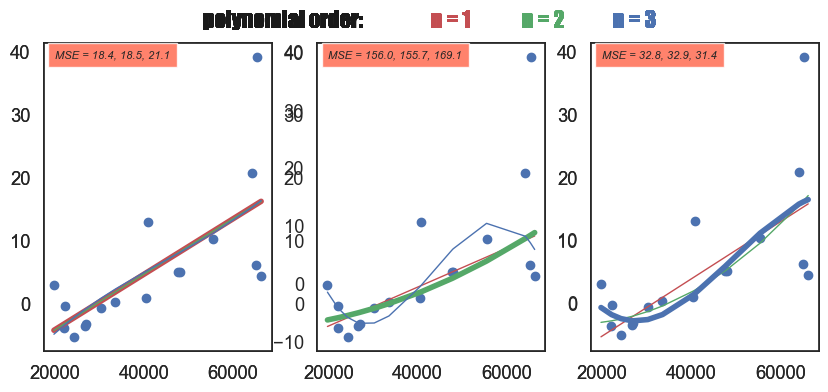

In [57]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break

plt.show()

In [58]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))

In [61]:
#id_airport = 1129804 
nb_folds = 10
test2 = get_flight_delays(df, carrier, id_airport, True)
fit = fit_polynome_cv(test2)
for i in range(1,4):
    fit.train(pol_order = i, nb_folds = nb_folds)
    fit.calc_score(pol_order = i, nb_folds = nb_folds)
    print("polynomial order: {}, MSE = {:.1f}".format(i, fit.score))



C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
C:\Users\Diluksha Shamal\AppData\Local\Temp\ipykernel_16264\3917166102.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

InvalidParameterError: The 'scoring' parameter of check_scoring must be a str among {'jaccard', 'average_precision', 'precision_samples', 'accuracy', 'neg_mean_absolute_error', 'r2', 'recall_macro', 'roc_auc', 'roc_auc_ovr_weighted', 'jaccard_macro', 'jaccard_micro', 'roc_auc_ovo_weighted', 'adjusted_rand_score', 'fowlkes_mallows_score', 'neg_log_loss', 'neg_mean_gamma_deviance', 'recall', 'top_k_accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'neg_negative_likelihood_ratio', 'neg_mean_absolute_percentage_error', 'completeness_score', 'explained_variance', 'mutual_info_score', 'adjusted_mutual_info_score', 'recall_micro', 'rand_score', 'roc_auc_ovr', 'precision_micro', 'recall_weighted', 'f1_samples', 'recall_samples', 'f1_micro', 'positive_likelihood_ratio', 'neg_median_absolute_error', 'v_measure_score', 'matthews_corrcoef', 'neg_brier_score', 'neg_root_mean_squared_error', 'max_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'roc_auc_ovo', 'normalized_mutual_info_score', 'balanced_accuracy', 'jaccard_samples', 'f1', 'jaccard_weighted', 'precision', 'neg_mean_poisson_deviance', 'homogeneity_score'}, a callable or None. Got 'mean_squared_error' instead.